In [43]:
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
# from slstm import sLSTM
from keras.layers import GRU
from keras import optimizers
from sklearn.svm import SVR
import numpy as np
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EA_NAME = ['soea_DE_best_1_bin_templet','soea_DE_best_1_L_templet','soea_DE_rand_1_bin_templet',
           'soea_SGA_templet','soea_EGA_templet','soea_steadyGA_templet','soea_studGA_templet','soea_SEGA_templet']#就最后一个有用


c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [44]:
def calcul_indicator(y,yhat):
    EV = 1 - np.var(y - yhat)/np.var(y)
    MAE = np.sum(np.abs((y - yhat)))/len(y)
    MSE = np.sum(np.multiply((y - yhat),(y - yhat)))/len(y)
    RMSE = sqrt(MSE)
    R_square = 1 - (((y - yhat)**2).sum())/(((y - y.mean())**2).sum())
    return [EV,MAE,MSE,RMSE,R_square]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



def LSTMM(train_X,train_y,test_X,test_y):
    # 将数据转换成3D进行输入
    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = Sequential()
    model.add(LSTM(70, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Compile model
    learning_rate = 0.0003
    decay_rate = learning_rate / 100
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate,
                                             nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
   
    history = model.fit(train_X_LSTM, train_y, epochs=60, batch_size=32, validation_data=(test_X_LSTM, test_y),
                        verbose=1, shuffle=False)
    yhat = model.predict(test_X_LSTM)
   
    yhat = yhat.reshape(len(yhat), 1)

    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y,yhat)



Epoch 1/60
21/21 [==============================] - 1s 9ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 2/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0531
Epoch 3/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0516
Epoch 4/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0503
Epoch 5/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0491
Epoch 6/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0479
Epoch 7/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0469
Epoch 8/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0459
Epoch 9/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0450
Epoch 10/60
21/21 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0441
Epoch 11/60
21/21 [

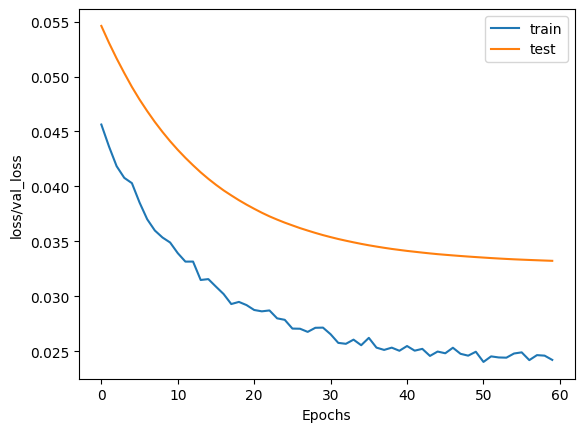

C:\Users\han\AppData\Local\Temp\ipykernel_20196\702211031.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)


ValueError: in user code:

    C:\Users\han\AppData\Local\Temp\ipykernel_20196\2533367922.py:147 call  *
        h, _ = self.lstm_cell(inputs, [h, c])
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\keras\layers\recurrent.py:2469 call
        c, o = self._compute_carry_and_output_fused(z, c_tm1)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\keras\layers\recurrent.py:2410 _compute_carry_and_output_fused
        c = f * c_tm1 + i * self.activation(z2)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:1383 binary_op_wrapper
        raise e
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:1710 _mul_dispatch
        return multiply(x, y, name=name)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:6244 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    c:\Users\han\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 280 and 70 for '{{node s_lstm_13/lstm_cell_28/mul}} = Mul[T=DT_FLOAT](s_lstm_13/lstm_cell_28/Sigmoid_1, s_lstm_13/add)' with input shapes: [?,?,280], [?,70].


In [45]:
if __name__ == '__main__':
    areas = ['DS1']
    indicator = ['EV','MAE','MSE','RMSE','R_square']

    # 如果是需要改动对比的算法，在这里进行改进即可
    classifers = [ 'LSTM', 'sLSTM', 'SEGA-LSTM', 'SEGA-sLSTM']
    df = pd.DataFrame(columns=classifers, index=indicator)
    #df = pd.DataFrame()
    for area in areas:
        path = './{}/'.format(area)
        pre_data_df = pd.read_csv(path+'8area_{}.csv'.format(area))
        # 对每种方法进行遍历
        for method in classifers:
            data_df  =pre_data_df
            if method[:3]=='SEG':
                res = pd.read_csv(path+'soea_SEGA_templet/optPop/Chrom.csv',header=None)
                values = res.values
                features = data_df.columns[1:]
                best_features = []
                best_features.append('label_M')
                for index in range(values.shape[1]):
                     if values[0][index] == 1:#筛选出来的特征，如果是1则选上，如果是0，则不选。
                         best_features.append(features[index])
                data_df = data_df[best_features]
            values = data_df.values
            values = values.astype('float32')
            #进行标准化的操作
            scaler = MinMaxScaler(feature_range = (0,1))
            scaled = scaler.fit_transform(values)
            reframed = series_to_supervised(scaled,1,1)
            reframed.drop(reframed.columns[[i for i in range(int(reframed.shape[1] / 2) + 1, reframed.shape[1])]], axis=1,inplace=True)

            #split into input
            values = reframed.values
            n_train_hours = int(reframed.shape[0]*0.7)
            train = values[:n_train_hours:]
            test = values[n_train_hours:,:]
            train_X,train_y = train[:,:-1],train[:,-1]
            test_X ,test_y = test[:,:-1],test[:,-1].reshape(-1, 1)
            if re.search('sLSTM', method):
                df.loc[:, method] = sLSTMM(train_X, train_y, test_X, test_y)
            elif re.search('LSTM', method):
                df.loc[:,method] = LSTMM(train_X,train_y,test_X,test_y)
            df.to_csv(path+'comparision_methodsss_{}.csv'.format(area))